Imports necessários para fazer os testes

In [1]:
import A_construct as c
import A_detect_II as d
import A_transform as t
from scipy.optimize import minimize
from matplotlib.backends.backend_pdf import PdfPages

#No ficheiro A_detect_LEQ fizemos a função auxiliar da função seguinte, detect_circles_color MODIFICADA, em que os parâmetros do HoughCircles são argumentos não establecidos desde o início
#Esta função é necessária para que se consiga aplicar uma função "solver" de forma a otimizar os parâmetros usados no algoritmo bem como a análise de sensibilidade aos mesmos

import cv2
import os
import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt
import math

#from __future__ import print_function
#from imutils import perspective
#from imutils import contours
import numpy as np
import cv2
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import statistics


import csv
from PIL import Image


In [2]:
#funções de display
def display_images(images):
    num_images = len(images)
    fig, ax = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        ax[i].imshow(images[i],cmap='gray')
        ax[i].set_title(f'Image {i+1}')
        ax[i].set_axis_off()
    plt.show()

def draw_circles(green_circles, output):
    image=output.copy()
    for circle in green_circles:
        x, y, r = circle
        image = cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        image = cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    return image


def apply_canny_edge_detection(image, low_threshold, high_threshold):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (21, 21), 0)

    # Step 2: Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=low_threshold,threshold2=high_threshold,apertureSize=5)

    # Step 3: Apply non-maximum suppression
    dx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
    gradient_direction = np.arctan2(dy, dx) * (180 / np.pi)
    gradient_direction = (gradient_direction + 180) % 180
    suppressed = np.zeros_like(edges)
    rows, cols = edges.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            direction = gradient_direction[i, j]
            if (0 <= direction < 22.5) or (157.5 <= direction <= 180):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i, j + 1]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i, j - 1]):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif (22.5 <= direction < 67.5):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j + 1]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j - 1]):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif (67.5 <= direction < 112.5):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j]):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif (112.5 <= direction < 157.5):
                if (gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j - 1]) and (
                        gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j + 1]):
                    suppressed[i, j] = gradient_magnitude[i, j]

    # Step 4: Apply hysteresis thresholding
    thresholded= cv2.Canny(blurred, threshold1=low_threshold,threshold2=high_threshold,apertureSize=5)

    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)
    sobel = cv2.convertScaleAbs(sobel)

    # Create a new image by horizontally concatenating the processed images
    #output = np.hstack((gray,blurred, sobel, suppressed, thresholded))
    output=thresholded
    return output



def detect_circles_final(img_color,img_canny,dp, center_dist,param2,minR, maxR,tolerancia,tolerancia_int):
    #Antes  detect_circles_final(img_color,img_canny,tolerancia,tolerancia_int,minR, maxR)
    sum_int=int((maxR-minR)/4)
    one=minR
    #two=55
    #tree=85
    two=minR+sum_int
    three=two+sum_int
    four=maxR
    p2=param2

    first=d.detect_circles_color(img_color,img_canny,dp,center_dist,param2=p2/6,minR=one,maxR=two,tolerancia=80,tolerancia_int=1)
    second=d.detect_circles_color(img_color,img_canny,dp,center_dist,param2=p2*0.5,minR=two,maxR=three,tolerancia=50,tolerancia_int=1)
    third=d.detect_circles_color(img_color,img_canny,dp,center_dist,param2=p2,minR=three,maxR=four,tolerancia=20,tolerancia_int=1)
    small=first[3]
    small_image=first[0]
  
    medium=second[3]
    medium_image=second[0]
    big=third[3]
    big_image=third[0]

    inicial=d.remove_repeated_circles_mod(small,medium,tolerance=1)
    final=d.remove_repeated_circles_mod(big,inicial,tolerance=1)
    
    return[final,small_image,medium_image,big_image]


def detect_circles_score(img_color, original_circles, detected_circles, tolerance=1, radius_margin=1):
    # Extract the centers and radii from the detected circles
    # Convert the expected circles to NumPy arrays, converting string values to integers
    original_centers = np.array(original_circles, dtype=int)[:, :2]
    original_radii = np.array(original_circles, dtype=int)[:, 2]
    
    
    detected_circles = np.array(detected_circles)
    detected_centers = detected_circles[:, :2]
    detected_radii = detected_circles[:, 2]
    number_of_P=len(detected_radii)

    #print('detetados',len(detected_radii))
    #print('média detetados', statistics.mean(detected_radii))
    #print(detected_radii)
    #print('detetados/numero de colocados', sum(detected_radii)/len(original_radii))
    #print(original_radii)
    #print('colocados', statistics.mean(original_radii))
    # Initialize arrays to store which circles were correctly detected
    placed_circles = np.zeros(len(original_centers))
    total_number_of_circles=len(placed_circles)

    flag=0
    img=img_color.copy()
    

    # Check if each original circle has a corresponding detected circle within the given tolerance
    for i, (oc, orad) in enumerate(zip(original_centers, original_radii)):
        distances = np.linalg.norm(detected_centers - np.array(oc), axis=1)
        #print(distances)
        if list(distances)==[]:
            #print('Hello?')
            break

        matches = np.argmin(distances)
        #if distances[matches]>10:
            #img=cv2.line(imagem,oc,detected_centers[matches], (255,0,0), 9)
        if distances[matches]<= tolerance*orad:

            flag=flag+1

            # If there is a match, check if the radii match within the given margin
            detected_radius = detected_radii[matches]
            if abs((orad-detected_radius))<=radius_margin*orad:
                # If the radii match within the margin, mark the original circle and detected circle as correct
                placed_circles[i] = 1

                # Remove the detected circle so it can't be matched to another original circle
                detected_centers = np.delete(detected_centers, matches, axis=0)
                detected_radii = np.delete(detected_radii, matches)
            else:
                
                img=cv2.circle(img, oc, int(orad), (255, 0, 0), 2)
        else:
            
            img=cv2.circle(img, oc, int(orad), (255, 0, 0), 2)

    for f in range(len(detected_radii)):
        det_rad = detected_radii[f]
        det_center = detected_centers[f]
        img = cv2.circle(img, tuple(det_center), int(det_rad), (0, 0, 255), 2)

    number_of_FP=len(detected_radii)
    # Calculate the percentage of correct detections
    number_of_TP=np.sum(placed_circles)
    number_of_FN=total_number_of_circles-number_of_P
    #print('numero de Fn',number_of_FN)
    #print('number of p',number_of_P)
    #print('number of tp', number_of_TP)

    recall = number_of_TP / total_number_of_circles * 100

    #number_of_FP= number_of_P - number_of_TP

    precision=number_of_TP/number_of_P*100
    #print('recall',recall)
    #print('precision',precision)

    return [recall,img,precision]


def count_size(image_path):

    img = Image.open(image_path)
    width, height = img.size

    return width, height

In [3]:
import pandas as pd
import glob

# Specify the directory where your CSV files are located
directory = r"C:\Users\evinh\OneDrive\Ambiente de Trabalho\LLE-main"

# Get a list of all CSV files in the directory
csv_files = glob.glob(directory + '\\*.csv')

# Initialize an empty list to store the data from each CSV
data = []

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file and append its data to the list
    df = pd.read_csv(file)
    data.append(df)

# Concatenate all the data into a single DataFrame
concatenated_data = pd.concat(data, ignore_index=True)

# Save the concatenated data to a new CSV file
concatenated_data.to_csv( r"C:\Users\evinh\OneDrive\Ambiente de Trabalho\LLE-main\anotados e encontrados\anotados_c1_1.csv", index=False)



In [4]:
def process_csv_and_images_folder(folder_path,dp, center_dist,param2,minR,maxR):
    # Get a list of all the CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    anotados = []
    encontrados = []
    recall_list = []
    precision_list = []
    Vol_anotados = []
    Vol_encontrados = []
    circ_encon=[]

    for csv_file in csv_files:
        # Find the corresponding image file with the same name as the CSV file (but ending with '.jpg')
        csv_file_name = os.path.splitext(csv_file)[0]
        #print(csv_file_name)
        image_file_name = csv_file_name + '.jpg'
        image_file_path = os.path.join(folder_path, image_file_name)
        im_right = cv2.imread(image_file_name)
        # Resize the image
        desired_width = 1000
        desired_height = 2000
        im_right = cv2.resize(im_right, (desired_width, desired_height))

        # Apply Canny edge detection with the specified thresholds
        low_threshold = 50
        high_threshold = 110
        result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
        result=t.apply_morphology_operations(result)


        #circle detection
        resultado=detect_circles_final(im_right,result,dp, center_dist,param2,minR,maxR,tolerancia=10,tolerancia_int=1)
        #detect_circles_final(img_color,img_canny,dp, center_dist,param2,minR, maxR,tolerancia,tolerancia_int)
        #Antes  detect_circles_final(img_color,img_canny,tolerancia,tolerancia_int,minR, maxR)      30 150
        circulos_encontrados=resultado[0]
        circ_encon.append(circulos_encontrados)
        raios_encontrados = [int(circle[2]) for circle in circulos_encontrados]

        #imagem_final_2=d.draw_green_circles(lista_2,im_right)

        #csv open and analise
        file_right = open (csv_file)
        csvreader = csv.reader(file_right)
        circulos_anotados = []
        for row in csvreader:
            circulos_anotados.append(row)
        #print(rows)
        file_right.close()
        raios_anotados = [int(circle[2]) for circle in circulos_anotados]

        Valor=detect_circles_score(im_right,circulos_anotados,circulos_encontrados,tolerance=0.5,radius_margin=0.5)

        anotados.append(raios_anotados)
        encontrados.append(raios_encontrados)
        recall_list.append(Valor[0])
        precision_list.append(Valor[2])

        v_anotadas = [(4/3) * math.pi * (radius ** 3) for radius in raios_anotados]
        Vol_anotados.append(sum(v_anotadas))

        v_encontrados = [(4/3) * math.pi * (radius ** 3) for radius in raios_encontrados]
        Vol_encontrados.append(sum(v_encontrados))

    anotados = [radius for sublist in anotados for radius in sublist]
    encontrados = [radius for sublist in encontrados for radius in sublist]
    circ_encon=[radius for sublist in circ_encon for radius in sublist]
    print(anotados)
    print(encontrados)
    print(recall_list)
    print(precision_list)
    print(Vol_anotados)
    print(Vol_encontrados)
    print(circ_encon)

    return anotados, encontrados, recall_list, precision_list, Vol_anotados, Vol_encontrados,circ_encon

In [5]:
def process_csv_and_images(folder_path,dp, center_dist,param2,minR,maxR):
    # Get a list of all the CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    anotados = []
    encontrados = []
    recall_list = []
    precision_list = []
    Vol_anotados = []
    Vol_encontrados = []
    circ_encon=[]

    for csv_file in csv_files:
        # Find the corresponding image file with the same name as the CSV file (but ending with '.jpg')
        csv_file_name = os.path.splitext(csv_file)[0]
        print(csv_file_name)
        image_file_name = csv_file_name + '.jpg'
        image_file_path = os.path.join(folder_path, image_file_name)
        im_right = cv2.imread(image_file_name)
        # Resize the image
        desired_width = 1000
        desired_height = 2000
        im_right = cv2.resize(im_right, (desired_width, desired_height))

        # Apply Canny edge detection with the specified thresholds
        low_threshold = 50
        high_threshold = 110
        result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
        result=t.apply_morphology_operations(result)


        #circle detection
        resultado=detect_circles_final(im_right,result,dp, center_dist,param2,minR,maxR,tolerancia=10,tolerancia_int=1)
        #detect_circles_final(img_color,img_canny,dp, center_dist,param2,minR, maxR,tolerancia,tolerancia_int)
        #Antes  detect_circles_final(img_color,img_canny,tolerancia,tolerancia_int,minR, maxR)      30 150
        circulos_encontrados=resultado[0]
        circ_encon.append(circulos_encontrados)
        raios_encontrados = [int(circle[2]) for circle in circulos_encontrados]

        #imagem_final_2=d.draw_green_circles(lista_2,im_right)

        #csv open and analise
        file_right = open (csv_file)
        csvreader = csv.reader(file_right)
        circulos_anotados = []
        for row in csvreader:
            circulos_anotados.append(row)
        #print(rows)
        file_right.close()
        raios_anotados = [int(circle[2]) for circle in circulos_anotados]

        Valor=detect_circles_score(im_right,circulos_anotados,circulos_encontrados,tolerance=0.5,radius_margin=0.5)

        anotados.append(raios_anotados)
        encontrados.append(raios_encontrados)
        recall_list.append(Valor[0])
        precision_list.append(Valor[2])

        v_anotadas = [(4/3) * math.pi * (radius ** 3) for radius in raios_anotados]
        Vol_anotados.append(sum(v_anotadas))

        v_encontrados = [(4/3) * math.pi * (radius ** 3) for radius in raios_encontrados]
        Vol_encontrados.append(sum(v_encontrados))

    anotados = [radius for sublist in anotados for radius in sublist]
    encontrados = [radius for sublist in encontrados for radius in sublist]
    circ_encon=[radius for sublist in circ_encon for radius in sublist]
    print(anotados)
    print(encontrados)
    print(recall_list)
    print(precision_list)
    print(Vol_anotados)
    print(Vol_encontrados)
    print(circ_encon)

    return anotados, encontrados, recall_list, precision_list, Vol_anotados, Vol_encontrados,circ_encon



caminho_da_pasta=r"C:\Users\evinh\OneDrive\Ambiente de Trabalho\LLE-main"

ip=[1.5,10,50,30,150]
ip_n=[1.69,15,200,34.49,112.24]

stat=process_csv_and_images(caminho_da_pasta,ip_n[0],ip_n[1],ip_n[2],ip_n[3],ip_n[4])

print(stat)

1baixo
1cima
1meio
2baixo
2cima
2meio
3baixo
3cima
3meio
4baixo
4cima
4meio
5baixo
5cima
5meio
6cima
[102, 72, 70, 60, 58, 123, 69, 64, 35, 42, 81, 98, 67, 79, 57, 63, 52, 30, 45, 16, 16, 48, 23, 21, 37, 17, 44, 47, 26, 32, 44, 47, 47, 34, 30, 20, 28, 21, 28, 35, 32, 24, 23, 65, 41, 49, 42, 58, 13, 0, 25, 21, 19, 23, 33, 39, 28, 40, 26, 42, 35, 37, 19, 18, 42, 34, 28, 53, 39, 25, 30, 28, 57, 16, 30, 30, 19, 35, 49, 37, 23, 30, 23, 19, 77, 19, 21, 35, 44, 30, 32, 26, 18, 19, 23, 28, 30, 35, 32, 23, 23, 53, 42, 33, 38, 37, 37, 30, 21, 27, 35, 30, 40, 27, 39, 37, 33, 30, 25, 23, 18, 18, 28, 19, 18, 19, 30, 30, 42, 35, 26, 26, 16, 19, 21, 31, 72, 69, 46, 54, 30, 49, 60, 27, 23, 40, 51, 88, 47, 44, 51, 37, 49, 62, 44, 26, 58, 60, 67, 48, 35, 30, 50, 67, 25, 37, 28, 35, 42, 49, 31, 27, 32, 46, 51, 51, 53, 41, 27, 60, 51, 24, 28, 40, 42, 28, 46, 39, 26, 77, 40, 41, 33, 30, 32, 47, 26, 25, 60, 37, 63, 90, 49, 74, 86, 69, 50, 61, 42, 21, 28, 71, 67, 44, 111, 70, 41, 54, 51, 74, 51, 21, 42, 19, 

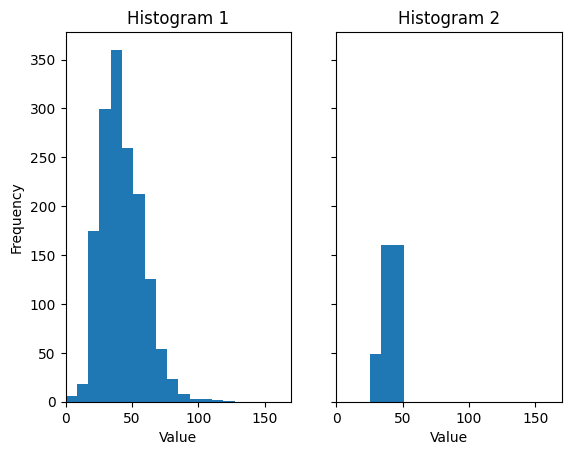

Sauter mean diameter for anotated: 59.806719599989535
Sauter mean diameter for found: 42.1807225525695
A media dos diametros dos anotados é 16.648790414233698 mm
A media dos diametros dos encontrados é 15.780039674065039 mm
A percentagem dos colocados encontrados é (Recall): 14.647627474379926 %
Precision: 68.75492854183926 %
Área Superficial dos anotados 531.4053230729503 mm2
Área Superficial dos encontrados 503.67605528455283 mm2
Volume dos anotados 2707997.3583018035 mm3
Volume dos encontrados 400865.5215783831 mm3


In [6]:
anotados, encontrados, recall_list, precision_list, Vol_anotados, Vol_encontrados,circ_encon=stat


import csv
def save_to_csv(anotados, file_path):
    # Open the CSV file in write mode
    with open(file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Write each radius as a separate row in the CSV file
        for radius in anotados:
            csv_writer.writerow([radius])

# Example usage

file_path = r"C:\Users\evinh\OneDrive\Ambiente de Trabalho\LLE-main\anotados e encontrados\anotados_c1_1.csv"
save_to_csv(circ_encon, file_path)



bins = 20
x_range = (0, 170)

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot the first histogram
ax1.hist(anotados, bins=bins, range=x_range)
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram 1')

# Plot the second histogram
ax2.hist(encontrados, bins=bins, range=x_range)
ax2.set_xlabel('Value')
ax2.set_title('Histogram 2')

# Set the x-axis range for both subplots
ax1.set_xlim(x_range)
ax2.set_xlim(x_range)

# Display the figure
plt.show()

import statistics


#List of all superficial arreas
SA_anotados=[]
SA_encontrados=[]

for i in anotados:
    SA_anotados.append(4*3.14159*i)


for j in encontrados:
    SA_encontrados.append(4*3.14159*j)

# List of radii for colocados

mm=0.393700787

# Calculate the total volume of colocados spheres
anotados_total_volume =sum([(4/3) * 3.14159 * radius**3 for radius in anotados])

# Calculate the volume fraction of each colocados sphere
anotados_volume_fractions =[(4/3) * 3.14159 * radius**3 / anotados_total_volume for radius in anotados]

# Calculate the Sauter mean diameter for colocados
anotados_sauter_mean_diameter = (sum([(radius * vf) for radius, vf in zip(anotados, anotados_volume_fractions)])) / sum(anotados_volume_fractions)

#Calculate the Superficial Area for colocados
#anotados_superficial_area = (sum([(radius**2 * vf) for radius, vf in zip(anotados, anotados_volume_fractions)])) *4*3.14159/ sum(anotados_volume_fractions)

# Calculate the total volume of verdes spheres
encontrados_total_volume = sum([(4/3) * 3.14159 * radius**3 for radius in encontrados])

# Calculate the volume fraction of each verdes sphere
encontrados_volume_fractions = [(4/3) * 3.14159 * radius**3 / encontrados_total_volume for radius in encontrados]

# Calculate the Sauter mean diameter for verdes
encontrados_sauter_mean_diameter = (sum([(radius * vf) for radius, vf in zip(encontrados, encontrados_volume_fractions)])) / sum(encontrados_volume_fractions)

#Calculate the Superficial Area for verdes
#encontrados_superficial_area = (sum([(radius * vf) for radius, vf in zip(encontrados, encontrados_volume_fractions)]))*4*3.14159 / sum(encontrados_volume_fractions)

dim=50

dp_valores=np.linspace(1, 3, num=dim)
cd_valores=np.linspace(2, 20, num=dim)
p2_valores=np.linspace(120, 220, num=dim)
minR_valores=np.linspace(10, 50, num=dim)
maxR_valores=np.linspace(100,200, num=dim)


i_p=[1.5,10,50,30,150]
pasta=r"C:\Users\evinh\OneDrive\Ambiente de Trabalho\LLE-main"



print("Sauter mean diameter for anotated:", anotados_sauter_mean_diameter)
print("Sauter mean diameter for found:", encontrados_sauter_mean_diameter)

# Calculate and print the statistics
print('A media dos diametros dos anotados é',mm*statistics.mean(anotados),'mm')
print('A media dos diametros dos encontrados é',mm*statistics.mean(encontrados),'mm')
print('A percentagem dos colocados encontrados é (Recall):', statistics.mean(recall_list),'%')
print('Precision:', statistics.mean(precision_list),'%')

V_med_anotados=statistics.mean(Vol_anotados)
V_med_encontrados=statistics.mean(Vol_encontrados)

print('Área Superficial dos anotados',statistics.mean(SA_anotados),'mm2')
print('Área Superficial dos encontrados',statistics.mean(SA_encontrados),'mm2')

print('Volume dos anotados',mm**3*V_med_anotados,'mm3')
print('Volume dos encontrados',mm**3*V_med_encontrados,'mm3')

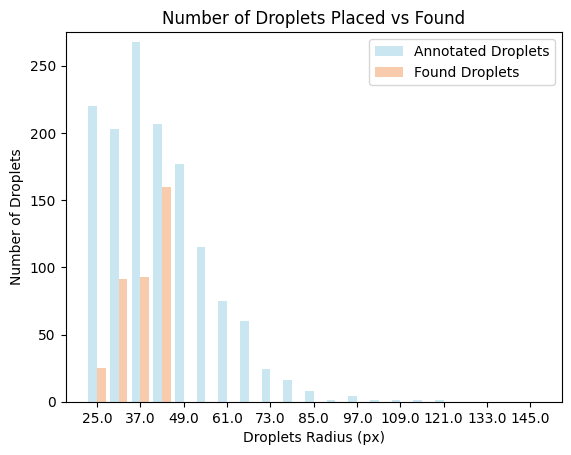

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the diam_max and diam_min values
diam_max = 300
diam_min = 70

# Calculate the maximum and minimum radii
maxR = diam_max / 2
minR = (diam_min / 2)-10

# Calculate the sum and create the bins
sum_bins = int((maxR - minR) / 20)
bins = np.arange(minR, maxR + sum_bins, sum_bins)

# Compute the histograms
col = np.histogram(anotados, bins=bins)[0]
ver = np.histogram(encontrados, bins=bins)[0]

X = [f'{bins[i]}' for i in range(len(bins)-1)] 

X_axis = np.arange(len(X))

col_color = (201/255, 230/255, 241/255)  # RGB tuple for a bluish color
ver_color = (248/255, 203/255, 173/255)  # RGB tuple for a reddish color

plt.bar(X_axis - 0.2, col, 0.4, label='Annotated Droplets', color=col_color)
plt.bar(X_axis + 0.2, ver, 0.4, label='Found Droplets', color=ver_color)

plt.xticks(X_axis[::2], X[::2]) 
plt.xlabel("Droplets Radius (px)")
plt.ylabel("Number of Droplets")
plt.title("Number of Droplets Placed vs Found")
# Set the y-axis limits to be between 0 and 300
plt.ylim(0, 275)

plt.legend()
plt.show()

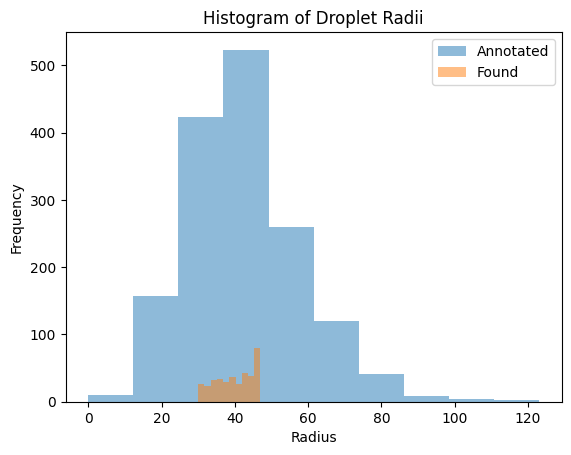

In [8]:
import matplotlib.pyplot as plt

# Assuming you have circle_list_ensaio1 and circle_list_ensaio2 defined

# Plotting the histograms
plt.hist(anotados, bins=10, alpha=0.5, label='Annotated')
plt.hist(encontrados, bins=10, alpha=0.5, label='Found')

plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Histogram of Droplet Radii')
plt.legend()

# Display the histogram
plt.show()


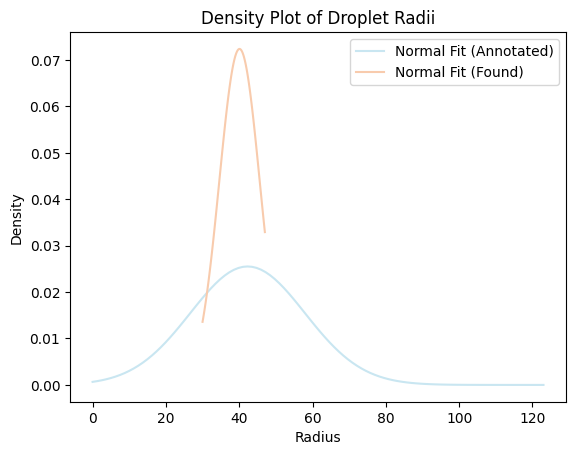

Estimated parameters for Camera 1:
μ (mu): 42.28792769528728
σ (sigma): 15.633090994837652

Estimated parameters for Camera 2:
μ (mu): 40.08130081300813
σ (sigma): 5.511643495913238


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

mu_c1, sigma_c1 = norm.fit(anotados)

# Fit normal distribution to the data for Camera 2
mu_c2, sigma_c2 = norm.fit(encontrados)

# Generate the x-axis values for the probability density functions (pdf)
x_c1 = np.linspace(min(anotados), max(anotados), 100)
x_c2 = np.linspace(min(encontrados), max(encontrados), 100)

# Compute the corresponding probability density functions (pdf)
pdf_c1 = norm.pdf(x_c1, mu_c1, sigma_c1)
pdf_c2 = norm.pdf(x_c2, mu_c2, sigma_c2)


col_color = (201/255, 230/255, 241/255)  # RGB tuple for a bluish color
ver_color = (248/255, 203/255, 173/255)  # RGB tuple for a reddish color

# Plotting the normal curves
plt.plot(x_c1, pdf_c1, color=col_color, label='Normal Fit (Annotated)')
plt.plot(x_c2, pdf_c2, color=ver_color, label='Normal Fit (Found)')

plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Density Plot of Droplet Radii')

plt.legend()

# Display the plot
plt.show()

# Print the estimated μ (mu) and σ (sigma) parameters
print("Estimated parameters for Camera 1:")
print("μ (mu):", mu_c1)
print("σ (sigma):", sigma_c1)

print("\nEstimated parameters for Camera 2:")
print("μ (mu):", mu_c2)
print("σ (sigma):", sigma_c2)

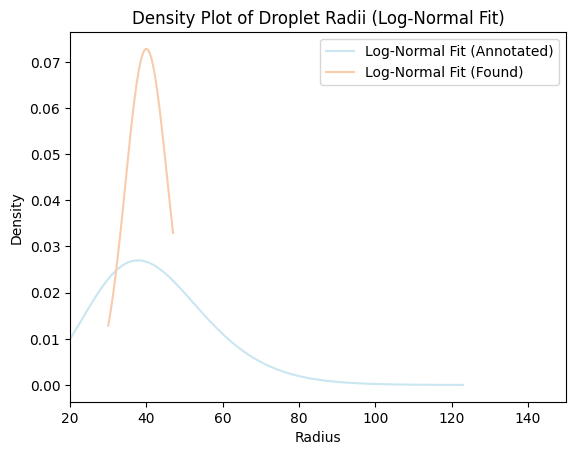

Estimated parameters for Log-Normal Fit (Annotated):
Shape: 0.2002014432972375
Location: -34.51516374837566
Scale: 75.27464324946695

Estimated parameters for Log-Normal Fit (Found):
Shape: 0.021142017856009637
Location: -219.144399252023
Scale: 259.2689278261483


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

# Fit log-normal distribution to the data for Camera 1
shape_c1, loc_c1, scale_c1 = lognorm.fit(anotados)

# Fit log-normal distribution to the data for Camera 2
shape_c2, loc_c2, scale_c2 = lognorm.fit(encontrados)

# Generate the x-axis values for the probability density functions (pdf)
x_c1 = np.linspace(min(anotados), max(anotados), 100)
x_c2 = np.linspace(min(encontrados), max(encontrados), 100)

# Compute the corresponding probability density functions (pdf)
pdf_c1 = lognorm.pdf(x_c1, shape_c1, loc=loc_c1, scale=scale_c1)
pdf_c2 = lognorm.pdf(x_c2, shape_c2, loc=loc_c2, scale=scale_c2)

col_color = (201/255, 230/255, 241/255)  # RGB tuple for a bluish color
ver_color = (248/255, 203/255, 173/255)  # RGB tuple for a reddish color

# Plotting the log-normal curves
plt.plot(x_c1, pdf_c1, color=col_color, label='Log-Normal Fit (Annotated)')
plt.plot(x_c2, pdf_c2, color=ver_color, label='Log-Normal Fit (Found)')

plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Density Plot of Droplet Radii (Log-Normal Fit)')

plt.xlim(20, 150)

plt.legend()

# Display the plot
plt.show()

# Print the estimated shape, location, and scale parameters for the log-normal distribution
print("Estimated parameters for Log-Normal Fit (Annotated):")
print("Shape:", shape_c1)
print("Location:", loc_c1)
print("Scale:", scale_c1)

print("\nEstimated parameters for Log-Normal Fit (Found):")
print("Shape:", shape_c2)
print("Location:", loc_c2)
print("Scale:", scale_c2)

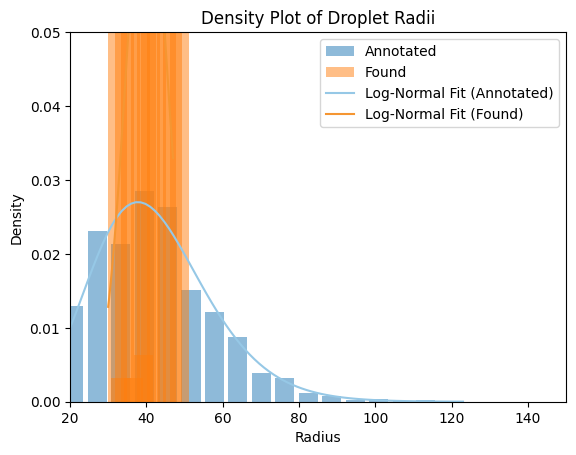


Estimated parameters for Log-Normal Fit (Annotated):
Shape: 0.2002014432972375
Loc: -34.51516374837566
Scale: 75.27464324946695

Estimated parameters for Log-Normal Fit (Found):
Shape: 0.021142017856009637
Loc: -219.144399252023
Scale: 259.2689278261483


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
# Assuming you have the data for all_radii and all_radii_2
all_radii = anotados  # Replace [...] with your actual data
all_radii_2 = encontrados  # Replace [...] with your actual data

# Generate the x-axis values for the probability density function (pdf)
x = np.linspace(min(all_radii), max(all_radii), 100)


# Plot the density histogram for all_radii with separated bars
plt.hist(all_radii, bins=20, density=True, alpha=0.5, label='Annotated', width=5)

# Plot the density histogram for all_radii_2 with separated bars
plt.hist(all_radii_2, bins=20, density=True, alpha=0.5, label='Found', width=5)


# Fit log-normal distribution to the data for Camera 1
shape_c1, loc_c1, scale_c1 = lognorm.fit(anotados)

# Fit log-normal distribution to the data for Camera 2
shape_c2, loc_c2, scale_c2 = lognorm.fit(encontrados)

# Generate the x-axis values for the probability density functions (pdf)
x_c1 = np.linspace(min(anotados), max(anotados), 100)
x_c2 = np.linspace(min(encontrados), max(encontrados), 100)

# Compute the corresponding probability density functions (pdf)
pdf_c1 = lognorm.pdf(x_c1, shape_c1, loc=loc_c1, scale=scale_c1)
pdf_c2 = lognorm.pdf(x_c2, shape_c2, loc=loc_c2, scale=scale_c2)

darker_blue = (150/255, 200/255, 230/255)
darker_orange = (245/255, 150/255, 50/255)


# Plotting the log-normal curves
plt.plot(x_c1, pdf_c1, color=darker_blue, label='Log-Normal Fit (Annotated)')
plt.plot(x_c2, pdf_c2, color=darker_orange, label='Log-Normal Fit (Found)')

plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Density Plot of Droplet Radii')
plt.ylim(0, 0.05)
plt.xlim(20, 150)
plt.legend()

# Display the plot
plt.show()


# Print the estimated shape, loc, and scale parameters for the log-normal fits
print("\nEstimated parameters for Log-Normal Fit (Annotated):")
print("Shape:", shape_c1)
print("Loc:", loc_c1)
print("Scale:", scale_c1)

print("\nEstimated parameters for Log-Normal Fit (Found):")
print("Shape:", shape_c2)
print("Loc:", loc_c2)
print("Scale:", scale_c2)

In [12]:
def f1_score(lista1,lista2):
    lista=[]
    for i in range(0,len(lista1)-1):
        lista.append(2*lista1[i]*lista2[i]/(lista1[i]+lista2[i]))
    return lista


1st Optimization and Sensibility Analysis (between ''')

ok
ok
recall: 15.942028985507244
precision: 37.93103448275862


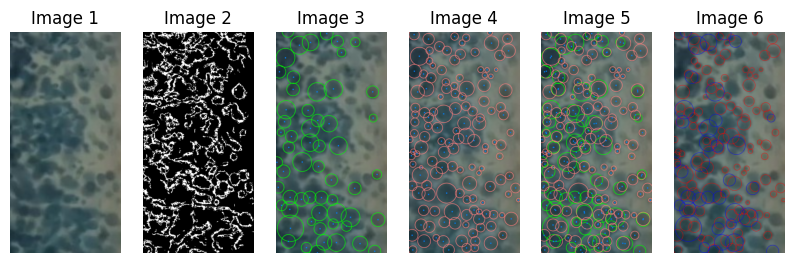

Raio Máximo Anotados: 90.0 px
Raio Máximo Encontrados: 47 px
Raio Mínimo Anotados 16.0 px
Raio Mínimo Encontrados: 30 px
Média de Raios Anotados: 42.210144927536234 px
Média de Raios Encontrados: 38 px
Área Superficial Anotados 533283.3918750877 mm2
Área Superficial Encontrados 82812.22652831643 mm2
Volume Anotados: 3611868.98524948 mm3
Volume Encontrados: 433929.7117613126 mm3
Hold-Up Anotados: 3.768131682445542 %
Hold-Up Encontrados: 0.45270310233285593 %
recall: 11.594202898550725
precision: 57.14285714285714


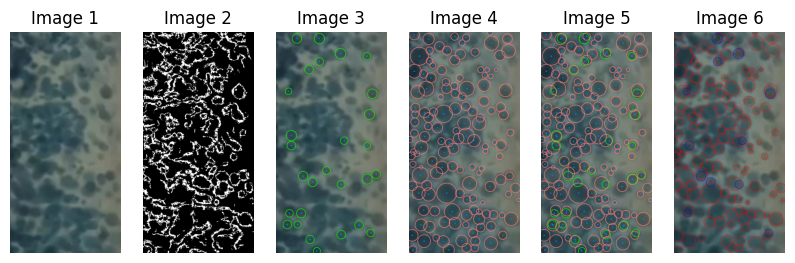

In [13]:
import os
import cv2

folder=r"C:\Users\evinh\OneDrive\Ambiente de Trabalho\LLE-main"
csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
# Choose a random CSV file from the list
random_csv_file ="2meio.csv"
if random_csv_file is None:
    print('vazio')
else:
    print('ok')
# Find the corresponding image file with the same name as the random CSV file (but ending with '.jpg')

image_file_path = '2meio.jpg'

if image_file_path is None:
    print('vazio')
else:
    print('ok')

file_right = open (random_csv_file)
csvreader = csv.reader(file_right)
rows = []
for row in csvreader:
    rows.append(row)
file_right.close()

#print(rows)

im_right = cv2.imread(image_file_path)
desired_width = 1000
desired_height = 2000
# Resize the image
im_right = cv2.resize(im_right, (desired_width, desired_height))
# Read the input image
low_threshold = 70
high_threshold = 110
# Apply Canny edge detection with the specified thresholds
result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
result=t.apply_morphology_operations(result)

Tol=50
Tol_int=10
diam_min=10
diam_max=100


dp_2=1.5
center_dist_2=10
param2_2=50
minR_2=35
maxR_2=150

resultado=detect_circles_final(im_right,result,dp_2, center_dist_2,param2_2,minR_2,maxR_2,tolerancia=10,tolerancia_int=1)

lista_2=resultado[0]


imagem_final_2=d.draw_green_circles(lista_2,im_right)

imagem_final_2_5=d.draw_blue_circles(rows,im_right)

imagem_final_3=d.draw_blue_circles(rows,imagem_final_2)


#detect_circles_score(img_color, original_circles, detected_circles, tolerance=1, radius_margin=1):
Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
print('recall:',Valor[0])
print('precision:',Valor[2])


imagens=[im_right,result,imagem_final_2,imagem_final_2_5,imagem_final_3,Valor[1]]

display_images(imagens)

dim=50

dp_valores=np.linspace(1, 2, num=dim)
cd_valores=np.linspace(2, 20, num=dim)
p2_valores=np.linspace(30, 100, num=dim)
minR_valores=np.linspace(5, 60, num=dim)
maxR_valores=np.linspace(100,250, num=dim)

'''
#dp
dp_recall=[]
dp_precision=[]
for i in dp_valores:
    resultado=detect_circles_final(im_right,result,i, center_dist_2,param2_2,minR_2,maxR_2,tolerancia=10,tolerancia_int=1)
    lista_2=resultado[0]
    Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
    dp_recall.append(Valor[0])
    dp_precision.append(Valor[2])

print(dp_valores)
print(dp_recall)
print(dp_precision)

#Find the optimal value
max_f1_score=max(f1_score(dp_recall,dp_precision))
max_f1_score_index=f1_score(dp_recall,dp_precision).index(max_f1_score)
print(dp_valores[max_f1_score_index])


plt.plot(dp_valores, dp_recall, color=col_color, label='Recall')
plt.plot(dp_valores, dp_precision, color=ver_color, label='Precision')

plt.xlabel('dp')
plt.ylabel('%')
plt.title('Influência do parâmetro dp')
plt.legend()
plt.show()

'''

dp_escolhido=1.69


'''

#center_dist
cd_recall=[]
cd_precision=[]

for i in cd_valores:
    resultado=detect_circles_final(im_right,result,dp_escolhido, i,param2_2,minR_2,maxR_2,tolerancia=10,tolerancia_int=1)
    lista_2=resultado[0]
    Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
    cd_recall.append(Valor[0])
    cd_precision.append(Valor[2])

print(cd_valores)
print(cd_recall)
print(cd_precision)

#Find the optimal value
max_f1_score=max(f1_score(cd_recall,cd_precision))
max_f1_score_index=f1_score(cd_recall,cd_precision).index(max_f1_score)
print(cd_valores[max_f1_score_index])

plt.plot(cd_valores, cd_recall, color=col_color, label='Recall')
plt.plot(cd_valores, cd_precision, color=ver_color, label='Precision')

plt.xlabel('center_dist')
plt.ylabel('%')
plt.title('Influência do parâmetro center_dist')
plt.legend()
plt.show()

'''

cd_escolhido=15

'''

#param2

p2_recall=[]
p2_precision=[]

for i in p2_valores:
    resultado=detect_circles_final(im_right,result,dp_escolhido, cd_escolhido,i,minR_2,maxR_2,tolerancia=10,tolerancia_int=1)
    lista_2=resultado[0]
    Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
    p2_recall.append(Valor[0])
    p2_precision.append(Valor[2])

print(p2_valores)
print(p2_recall)
print(p2_precision)

#Find the optimal value
max_f1_score=max(f1_score(p2_recall,p2_precision))
max_f1_score_index=f1_score(p2_recall,p2_precision).index(max_f1_score)
print(p2_valores[max_f1_score_index])

plt.plot(p2_valores, p2_recall, color=col_color, label='Recall')
plt.plot(p2_valores, p2_precision, color=ver_color, label='Precision')

plt.xlabel('param2')
plt.ylabel(' %')
plt.title('Influência do parâmetro param2')
plt.legend()
plt.show()

'''

p2_escolhido=200

'''

#minR

minR_recall=[]
minR_precision=[]

for i in minR_valores:
    resultado=detect_circles_final(im_right,result,dp_escolhido, cd_escolhido,p2_escolhido,i,maxR_2,tolerancia=10,tolerancia_int=1)
    lista_2=resultado[0]
    Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
    minR_recall.append(Valor[0])
    minR_precision.append(Valor[2])

print(minR_valores)
print(minR_recall)
print(minR_precision)

#Find the optimal value
max_f1_score=max(f1_score(minR_recall,minR_precision))
max_f1_score_index=f1_score(minR_recall,minR_precision).index(max_f1_score)
print(minR_valores[max_f1_score_index])

plt.plot(minR_valores, minR_recall, color=col_color, label='Recall')
plt.plot(minR_valores, minR_precision, color=ver_color, label='Precision')

plt.xlabel('minR')
plt.ylabel('%')
plt.title('Influência do parâmetro minR')
plt.legend()
plt.show()

'''

minR_escolhido=34.49

'''

#maxR

maxR_recall=[]
maxR_precision=[]

for i in maxR_valores:
    resultado=detect_circles_final(im_right,result,dp_escolhido, cd_escolhido,p2_escolhido,minR_escolhido,i,tolerancia=10,tolerancia_int=1)
    lista_2=resultado[0]
    Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
    maxR_recall.append(Valor[0])
    maxR_precision.append(Valor[2])

print(maxR_valores)
print(maxR_recall)
print(maxR_precision)

#Find the optimal value
max_f1_score=max(f1_score(maxR_recall,maxR_precision))
max_f1_score_index=f1_score(maxR_recall,maxR_precision).index(max_f1_score)
print(maxR_valores[max_f1_score_index])

plt.plot(maxR_valores, maxR_recall, color=col_color, label='Recall')
plt.plot(maxR_valores, maxR_precision, color=ver_color, label='Precision')

plt.xlabel('maxR')
plt.ylabel(' %')
plt.title('Influência do parâmetro maxR')
plt.legend()
plt.show()

'''
maxR_escolhido=112.24


dp_2=dp_escolhido
center_dist_2=cd_escolhido
param2_2=p2_escolhido
minR_2=minR_escolhido
maxR_2=maxR_escolhido

resultado=detect_circles_final(im_right,result,dp_2, center_dist_2,param2_2,minR_2,maxR_2,tolerancia=10,tolerancia_int=1)
#detect_circles_final(img_color,img_canny,dp, center_dist,param2,minR, maxR,tolerancia,tolerancia_int)
#Antes  detect_circles_final(img_color,img_canny,tolerancia,tolerancia_int,minR, maxR)      35 150
lista_2=resultado[0]

vol_parte_coluna=2000*3.1415*500**2
raios_anotados = [float(circle [2]) for circle in rows]
raios_encontrados = [circle [2] for circle in lista_2]
a_sup_anotados=sum([4*3.14159*float(circle [2])**2 for circle in rows])
a_sup_encontrados=sum([4*3.14159*(circle [2])**2 for circle in lista_2])
vol_anotados=sum([(4/3)*3.14159*(float(circle [2]))**3 for circle in rows])
vol_encontrados=sum([(4/3)*3.14159*(circle [2])**3 for circle in lista_2])
hold_up_anotados=vol_anotados/vol_parte_coluna
hold_up_encontrados=vol_encontrados/vol_parte_coluna

raio_medio_anotado=statistics.mean(raios_anotados)
raio_medio_encontrado=statistics.mean(raios_encontrados)


raio_max_encontrado=max(raios_encontrados)
raio_max_anotado=max(raios_anotados)
raio_min_encontrado=min(raios_encontrados)
raio_min_anotado=min(raios_anotados)

print('Raio Máximo Anotados:',raio_max_anotado,'px')
print('Raio Máximo Encontrados:',raio_max_encontrado,'px')

print('Raio Mínimo Anotados',raio_min_anotado,'px')
print('Raio Mínimo Encontrados:',raio_min_encontrado,'px')

print('Média de Raios Anotados:',raio_medio_anotado,'px')
print('Média de Raios Encontrados:',raio_medio_encontrado,'px')

print('Área Superficial Anotados',a_sup_anotados*mm**2,'mm2')
print('Área Superficial Encontrados',a_sup_encontrados*mm**2,'mm2')

print('Volume Anotados:', vol_anotados*mm**3,'mm3')
print('Volume Encontrados:', vol_encontrados*mm**3,'mm3')

print('Hold-Up Anotados:', hold_up_anotados*100,'%')
print('Hold-Up Encontrados:', hold_up_encontrados*100, '%')


imagem_final_2=d.draw_green_circles(lista_2,im_right)

imagem_final_2_5=d.draw_blue_circles(rows,im_right)

imagem_final_3=d.draw_blue_circles(rows,imagem_final_2)


#detect_circles_score(img_color, original_circles, detected_circles, tolerance=1, radius_margin=1):
Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
print('recall:',Valor[0])
print('precision:',Valor[2])



imagens=[im_right,result,imagem_final_2,imagem_final_2_5,imagem_final_3,Valor[1]]

display_images(imagens)


2nd Optimization (Hold-Up Clsutering) - BAD IMPLEMENTATION

In [14]:
def process_image(image, anotations,dp,center_dist,param2,minR,maxR,initial_hold_up):
    file_right = open (anotations)
    csvreader = csv.reader(file_right)
    rows = []
    for row in csvreader:
        rows.append(row)
    file_right.close()

    im_right = cv2.imread(image)
    desired_width = 1000
    desired_height = 2000
    # Resize the image
    im_right = cv2.resize(im_right, (desired_width, desired_height))
    # Read the input image
    low_threshold = 70
    high_threshold = 110
    # Apply Canny edge detection with the specified thresholds
    result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
    result=t.apply_morphology_operations(result)

    Tol=50
    Tol_int=10
    diam_min=10
    diam_max=100

    low=[0,20]
    medium=[20,40]
    high=[40,100]


    #Paramethers for each range of Hold-up (l-low,m-medium,h-high) --ORDER:  dp,center_dist,param2,minR,maxR
    l=[1,7.142,57.14,36.53,148.98]
    m=[1.69,14.48,85.714,10.61,130.61]
    h=[1,11.92,45.71,19.59,148.97]

    resultado=detect_circles_final(im_right,result,dp,center_dist,param2,minR,maxR,tolerancia=10,tolerancia_int=1)
    lista_2=resultado[0]

    vol_parte_coluna=3.1415*2000*500**2
    raios_anotados = [float(circle [2]) for circle in rows]
    raios_encontrados = [circle [2] for circle in lista_2]
    a_sup_anotados=sum([4*3.14159*float(circle [2])**2 for circle in rows])
    a_sup_encontrados=sum([4*3.14159*(circle [2])**2 for circle in lista_2])
    vol_anotados=sum([(4/3)*3.14159*(float(circle [2]))**3 for circle in rows])
    vol_encontrados=sum([(4/3)*3.14159*(circle [2])**3 for circle in lista_2])
    hold_up_anotados=vol_anotados/vol_parte_coluna
    hold_up_encontrados=vol_encontrados/vol_parte_coluna

    raio_medio_anotado=statistics.mean(raios_anotados)
    raio_medio_encontrado=statistics.mean(raios_encontrados)


    raio_max_encontrado=max(raios_encontrados)
    raio_max_anotado=max(raios_anotados)
    raio_min_encontrado=min(raios_encontrados)
    raio_min_anotado=min(raios_anotados)

    if hold_up_encontrados==initial_hold_up:
        print('Raio Máximo Anotados:',raio_max_anotado,'px')
        print('Raio Máximo Encontrados:',raio_max_encontrado,'px')

        print('Raio Mínimo Anotados',raio_min_anotado,'px')
        print('Raio Mínimo Encontrados:',raio_min_encontrado,'px')

        print('Média de Raios Anotados:',raio_medio_anotado,'px')
        print('Média de Raios Encontrados:',raio_medio_encontrado,'px')

        print('Área Superficial Anotados',a_sup_anotados*mm**2,'mm2')
        print('Área Superficial Encontrados',a_sup_encontrados*mm**2,'mm2')

        print('Volume Anotados:', vol_anotados*mm**3,'mm3')
        print('Volume Encontrados:', vol_encontrados*mm**3,'mm3')

        print('Hold-Up Anotados:', hold_up_anotados*100,'%')
        print('Hold-Up Encontrados:', hold_up_encontrados*100, '%')

        imagem_final_2=d.draw_green_circles(lista_2,im_right)

        imagem_final_2_5=d.draw_blue_circles(rows,im_right)

        imagem_final_3=d.draw_blue_circles(rows,imagem_final_2)


        #detect_circles_score(img_color, original_circles, detected_circles, tolerance=1, radius_margin=1):
        Valor=detect_circles_score(im_right,rows,lista_2,tolerance=0.5,radius_margin=0.5)
        print('recall:',Valor[0])
        print('precision:',Valor[2])


        imagens=[im_right,result,imagem_final_2,imagem_final_2_5,imagem_final_3,Valor[1]]

        display_images(imagens)

    elif low[0]<= hold_up_encontrados<=low[1]:
        print('low',hold_up_encontrados)
        return process_image(image,anotations,l[0], l[1],l[2],l[3],l[4], hold_up_encontrados)
    elif medium[0]<hold_up_encontrados<=medium[1]:
        print('medium',hold_up_encontrados)
        return process_image(image,anotations,m[0], m[1],m[2],m[3],m[4],hold_up_encontrados)
    else:
        print('high',hold_up_encontrados)
        return process_image(image,anotations,h[0], h[1],h[2],h[3],h[4],hold_up_encontrados)

######################!!!!!!!!!!!!!!!!!!!!!!!



low 0.007824037475685712
low 0.008815321873915856
Raio Máximo Anotados: 77.0 px
Raio Máximo Encontrados: 58 px
Raio Mínimo Anotados 0.0 px
Raio Mínimo Encontrados: 39 px
Média de Raios Anotados: 31.598360655737704 px
Média de Raios Encontrados: 50 px
Área Superficial Anotados 271991.3003255392 mm2
Área Superficial Encontrados 123082.7784022684 mm2
Volume Anotados: 1462293.9073255653 mm3
Volume Encontrados: 844975.4508240481 mm3
Hold-Up Anotados: 1.5255581040572965 %
Hold-Up Encontrados: 0.8815321873915856 %
recall: 13.114754098360656
precision: 66.66666666666666


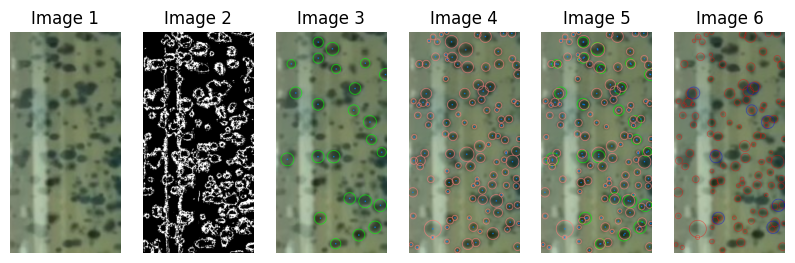

In [15]:
process_image('1cima.jpg', '1cima.csv',1.69,15,200,34.49,112.24,50)

#Esta abordagem não é Boa!!!!!!!

2nd Optimization (Hold-Up Clustering) - GOOD IMPLEMENTATION

In [16]:
def process_image2(image, anotations):
    file_right = open (anotations)
    csvreader = csv.reader(file_right)
    rows = []
    for row in csvreader:
        rows.append(row)
    file_right.close()

    im_right = cv2.imread(image)
    desired_width = 1000
    desired_height = 2000
    # Resize the image
    im_right = cv2.resize(im_right, (desired_width, desired_height))
    # Read the input image
    low_threshold = 70
    high_threshold = 110
    # Apply Canny edge detection with the specified thresholds
    result = apply_canny_edge_detection(im_right, low_threshold, high_threshold)
    result=t.apply_morphology_operations(result)

    Tol=50
    Tol_int=10
    diam_min=10
    diam_max=100

    low=[0,20]
    medium=[20,40]
    high=[40,100]


    #Paramethers for each range of Hold-up (l-low,m-medium,h-high) --ORDER:  dp,center_dist,param2,minR,maxR
    l=[1.898,7.1428,107.1428,20.20,182.65]
    m=[1,9.3469,64.28,35.51,148.98]
    h=[1.65306,11.183,50,35.51,100]

    #low

    l_resultado=detect_circles_final(im_right,result,l[0],l[1],l[2],l[3],l[4],tolerancia=10,tolerancia_int=1)
    l_lista=l_resultado[0]

    vol_parte_coluna=3.1415*2000*500**2
    raios_anotados = [float(circle [2]) for circle in rows]
    l_raios_encontrados = [circle [2] for circle in l_lista]
    a_sup_anotados=sum([4*3.14159*float(circle [2])**2 for circle in rows])
    l_a_sup_encontrados=sum([4*3.14159*(circle [2])**2 for circle in l_lista])
    vol_anotados=sum([(4/3)*3.14159*(float(circle [2]))**3 for circle in rows])
    l_vol_encontrados=sum([(4/3)*3.14159*(circle [2])**3 for circle in l_lista])
    hold_up_anotados=vol_anotados/vol_parte_coluna
    l_hold_up_encontrados=l_vol_encontrados/vol_parte_coluna


    #medium

    m_resultado=detect_circles_final(im_right,result,m[0],m[1],m[2],m[3],m[4],tolerancia=10,tolerancia_int=1)
    m_lista=m_resultado[0]

    vol_parte_coluna=3.1415*2000*500**2
    raios_anotados = [float(circle [2]) for circle in rows]
    m_raios_encontrados = [circle [2] for circle in m_lista]
    a_sup_anotados=sum([4*3.14159*float(circle [2])**2 for circle in rows])
    m_a_sup_encontrados=sum([4*3.14159*(circle [2])**2 for circle in m_lista])
    vol_anotados=sum([(4/3)*3.14159*(float(circle [2]))**3 for circle in rows])
    m_vol_encontrados=sum([(4/3)*3.14159*(circle [2])**3 for circle in m_lista])
    hold_up_anotados=vol_anotados/vol_parte_coluna
    m_hold_up_encontrados=m_vol_encontrados/vol_parte_coluna

    #High

    h_resultado=detect_circles_final(im_right,result,h[0],h[1],h[2],h[3],h[4],tolerancia=10,tolerancia_int=1)
    h_lista=h_resultado[0]

    vol_parte_coluna=2000*3.1415*500**2
    raios_anotados = [float(circle [2]) for circle in rows]
    h_raios_encontrados = [circle [2] for circle in h_lista]
    a_sup_anotados=sum([4*3.14159*float(circle [2])**2 for circle in rows])
    h_a_sup_encontrados=sum([4*3.14159*(circle [2])**2 for circle in h_lista])
    vol_anotados=sum([(4/3)*3.14159*(float(circle [2]))**3 for circle in rows])
    h_vol_encontrados=sum([(4/3)*3.14159*(circle [2])**3 for circle in h_lista])
    hold_up_anotados=vol_anotados/vol_parte_coluna
    h_hold_up_encontrados=h_vol_encontrados/vol_parte_coluna

    hold_up_max=max(l_hold_up_encontrados,m_hold_up_encontrados,h_hold_up_encontrados)

    if hold_up_max==l_hold_up_encontrados:

        lista=l_lista

        raio_medio_anotado=statistics.mean(raios_anotados)
        raio_medio_encontrado=statistics.mean(l_raios_encontrados)

        raio_max_encontrado=max(l_raios_encontrados)
        raio_max_anotado=max(raios_anotados)
        raio_min_encontrado=min(l_raios_encontrados)
        raio_min_anotado=min(raios_anotados)

        a_sup_encontrados=l_a_sup_encontrados 
        vol_encontrados=l_vol_encontrados

    elif hold_up_max==m_hold_up_encontrados:

        lista=m_lista

        raio_medio_anotado=statistics.mean(raios_anotados)
        raio_medio_encontrado=statistics.mean(m_raios_encontrados)

        raio_max_encontrado=max(m_raios_encontrados)
        raio_max_anotado=max(raios_anotados)
        raio_min_encontrado=min(m_raios_encontrados)
        raio_min_anotado=min(raios_anotados)

        a_sup_encontrados=m_a_sup_encontrados 
        vol_encontrados=m_vol_encontrados

    else:
        lista=h_lista

        raio_medio_anotado=statistics.mean(raios_anotados)
        raio_medio_encontrado=statistics.mean(h_raios_encontrados)

        raio_max_encontrado=max(h_raios_encontrados)
        raio_max_anotado=max(raios_anotados)
        raio_min_encontrado=min(h_raios_encontrados)
        raio_min_anotado=min(raios_anotados)

        a_sup_encontrados=h_a_sup_encontrados 
        vol_encontrados=h_vol_encontrados

    print('Raio Máximo Anotados:',raio_max_anotado,'px')
    print('Raio Máximo Encontrados:',raio_max_encontrado,'px')

    print('Raio Mínimo Anotados',raio_min_anotado,'px')
    print('Raio Mínimo Encontrados:',raio_min_encontrado,'px')

    print('Média de Raios Anotados:',raio_medio_anotado,'px')
    print('Média de Raios Encontrados:',raio_medio_encontrado,'px')

    print('Área Superficial Anotados',a_sup_anotados*mm**2,'mm2')
    print('Área Superficial Encontrados',a_sup_encontrados*mm**2,'mm2')

    print('Volume Anotados:', vol_anotados*mm**3,'mm3')
    print('Volume Encontrados:', vol_encontrados*mm**3,'mm3')

    print('Hold-Up Anotados:', hold_up_anotados*100,'%')
    print('Hold-Up Encontrados:', hold_up_max*100, '%')

    imagem_final_2=d.draw_green_circles(lista,im_right)

    imagem_final_2_5=d.draw_blue_circles(rows,im_right)

    imagem_final_3=d.draw_blue_circles(rows,imagem_final_2)


    #detect_circles_score(img_color, original_circles, detected_circles, tolerance=1, radius_margin=1):
    Valor=detect_circles_score(im_right,rows,lista,tolerance=0.5,radius_margin=0.5)
    print('recall:',Valor[0])
    print('precision:',Valor[2])


    imagens=[im_right,result,imagem_final_2,imagem_final_2_5,imagem_final_3,Valor[1]]

    display_images(imagens)




Raio Máximo Anotados: 90.0 px
Raio Máximo Encontrados: 90 px
Raio Mínimo Anotados 16.0 px
Raio Mínimo Encontrados: 32 px
Média de Raios Anotados: 42.210144927536234 px
Média de Raios Encontrados: 47 px
Área Superficial Anotados 533283.3918750877 mm2
Área Superficial Encontrados 387317.980175833 mm2
Volume Anotados: 3611868.98524948 mm3
Volume Encontrados: 2630707.248958775 mm3
Hold-Up Anotados: 3.768131682445542 %
Hold-Up Encontrados: 2.7445212914764703 %
recall: 29.71014492753623
precision: 48.80952380952381


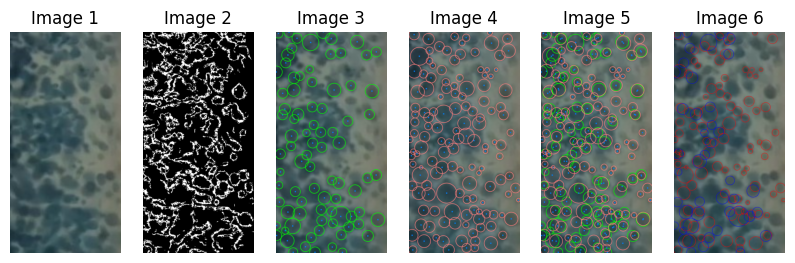

In [17]:
process_image2('2meio.jpg', '2meio.csv')